In [2]:
!nvidia-smi

Fri Apr 14 20:47:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms

import argparse

from tqdm import tqdm
import time

In [43]:
class ResnetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_, out, stride=1):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_, out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out)
        self.conv2 = nn.Conv2d(out, out, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ != self.expansion*out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_, self.expansion*out,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out)
            )

    def forward(self, x):
        out = F.gelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Resnet(nn.Module):
    def __init__(self, num_classes=10):
        super(Resnet, self).__init__()
        block, num_blocks = ResnetBlock, [2, 2, 2, 2]
        self.in_ = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 194, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, out, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_, out, stride))
            self.in_ = out * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.gelu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [44]:
model = Resnet().to('cuda')
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
       ResnetBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
      ResnetBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [62]:
class Trainer:
    def __init__(self,opt = 'sgd',epochs = 10,learning_rate = 0.01):
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = Resnet().to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.epochs = epochs
        self.opt = opt

        if opt == 'sgd':
            self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                momentum=0.9, weight_decay=5e-4)
        elif opt == 'adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate,
                                weight_decay=5e-4)
        elif opt == 'adadelta':
            self.optimizer = optim.Adadelta(self.model.parameters(), lr=learning_rate,
                                weight_decay=5e-4)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer,max_lr=learning_rate,total_steps=self.epochs)
    
    def load_data(self):
        print('\n\nLoading Dataset\n\n')
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        trainset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform_train)
        start = time.perf_counter()
        self.trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=32, shuffle=True)
        # print(time.perf_counter() - start)

        testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform_test)
        self.testloader = torch.utils.data.DataLoader(
            testset, batch_size=32, shuffle=False)
            
    def train(self):
        self.metrics = {
            'train': {
                'acc': [],
                'loss': []
            },
            'test': {
                'acc': [],
                'loss': []
            }
        }
        print('\n\nTraining\n\n')

        self.model.train()
        start = time.perf_counter()
        temp = 0
        min_valid_loss = 1000
        for ep in range(self.epochs):
            with tqdm(enumerate(self.trainloader),total=len(self.trainloader),desc = 'Epoch {}/{}'.format(ep+1,self.epochs),position = 0,leave=True) as tep:
                train_loss = 0
                # train_acc = 0
                correct = 0
                total = 0

                self.model.train()

                for batch_idx, (inputs, targets) in tep:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    self.optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)
                    loss.backward()
                    self.optimizer.step()

                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
                    tep.set_postfix_str('Train: loss={:.4f}, acc={:.4f}'.format(train_loss/(batch_idx+1),correct/total))
                
                self.model.eval()

                test_loss = 0
                test_acc = 0
                
                test_correct = 0
                test_total = 0
    
                with torch.no_grad():
                    for (inputs, targets) in self.testloader:
                        inputs = inputs.to(self.device)
                        targets = targets.to(self.device)
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, targets)
                        _, predicted = outputs.max(1)
                        test_total += targets.size(0)
                        test_correct += predicted.eq(targets).sum().item()
                        test_loss += loss.item()
                    print('Train: loss={:.4f}, acc={:.4f} | Test: loss={:.4f}, acc={:.4f}'.format(train_loss/(batch_idx+1),correct/total,test_loss/len(self.testloader),test_correct/test_total))
                self.metrics['train']['acc'].append(correct/total)
                self.metrics['train']['loss'].append(train_loss/(batch_idx+1))
                self.metrics['test']['acc'].append(test_correct/test_total)
                self.metrics['test']['loss'].append(test_loss/len(self.testloader))

                if min_valid_loss > test_loss/len(self.testloader):
                    min_valid_loss = test_loss/len(self.testloader)
                    torch.save(model,f'resent_modified_{self.opt}_{min_valid_loss}.pt')
                self.scheduler.step()

In [63]:
trainer = Trainer(epochs=50, opt='sgd', learning_rate=0.01)
trainer.load_data()
trainer.train()



Loading Dataset


Files already downloaded and verified
Files already downloaded and verified


Training




Epoch 1/50: 100%|██████████| 1563/1563 [01:05<00:00, 23.81it/s, Train: loss=1.5080, acc=0.4451]


Train: loss=1.5080, acc=0.4451 | Test: loss=1.1029, acc=0.5991


Epoch 2/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.17it/s, Train: loss=1.0340, acc=0.6321]


Train: loss=1.0340, acc=0.6321 | Test: loss=0.9847, acc=0.6628


Epoch 3/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s, Train: loss=0.8280, acc=0.7106]


Train: loss=0.8280, acc=0.7106 | Test: loss=0.8869, acc=0.7084


Epoch 4/50: 100%|██████████| 1563/1563 [01:05<00:00, 23.87it/s, Train: loss=0.7072, acc=0.7539]


Train: loss=0.7072, acc=0.7539 | Test: loss=0.6023, acc=0.7955


Epoch 5/50: 100%|██████████| 1563/1563 [01:05<00:00, 23.85it/s, Train: loss=0.6324, acc=0.7803]


Train: loss=0.6324, acc=0.7803 | Test: loss=0.5885, acc=0.7992


Epoch 6/50: 100%|██████████| 1563/1563 [01:05<00:00, 23.84it/s, Train: loss=0.5708, acc=0.8031]


Train: loss=0.5708, acc=0.8031 | Test: loss=0.5459, acc=0.8154


Epoch 7/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s, Train: loss=0.5120, acc=0.8237]


Train: loss=0.5120, acc=0.8237 | Test: loss=0.5368, acc=0.8169


Epoch 8/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.37it/s, Train: loss=0.4761, acc=0.8357]


Train: loss=0.4761, acc=0.8357 | Test: loss=0.4433, acc=0.8471


Epoch 9/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.60it/s, Train: loss=0.4382, acc=0.8483]


Train: loss=0.4382, acc=0.8483 | Test: loss=0.4914, acc=0.8348


Epoch 10/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s, Train: loss=0.4032, acc=0.8627]


Train: loss=0.4032, acc=0.8627 | Test: loss=0.4440, acc=0.8513


Epoch 11/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.71it/s, Train: loss=0.3798, acc=0.8688]


Train: loss=0.3798, acc=0.8688 | Test: loss=0.4019, acc=0.8643


Epoch 12/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.22it/s, Train: loss=0.3571, acc=0.8783]


Train: loss=0.3571, acc=0.8783 | Test: loss=0.3875, acc=0.8679


Epoch 13/50: 100%|██████████| 1563/1563 [01:05<00:00, 24.00it/s, Train: loss=0.3405, acc=0.8815]


Train: loss=0.3405, acc=0.8815 | Test: loss=0.3897, acc=0.8679


Epoch 14/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.65it/s, Train: loss=0.3180, acc=0.8900]


Train: loss=0.3180, acc=0.8900 | Test: loss=0.3535, acc=0.8799


Epoch 15/50: 100%|██████████| 1563/1563 [01:02<00:00, 24.82it/s, Train: loss=0.3008, acc=0.8967]


Train: loss=0.3008, acc=0.8967 | Test: loss=0.3396, acc=0.8828


Epoch 16/50: 100%|██████████| 1563/1563 [01:05<00:00, 24.02it/s, Train: loss=0.2926, acc=0.9004]


Train: loss=0.2926, acc=0.9004 | Test: loss=0.3719, acc=0.8789


Epoch 17/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.52it/s, Train: loss=0.2763, acc=0.9029]


Train: loss=0.2763, acc=0.9029 | Test: loss=0.3433, acc=0.8863


Epoch 18/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.39it/s, Train: loss=0.2630, acc=0.9092]


Train: loss=0.2630, acc=0.9092 | Test: loss=0.3495, acc=0.8851


Epoch 19/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s, Train: loss=0.2534, acc=0.9137]


Train: loss=0.2534, acc=0.9137 | Test: loss=0.3436, acc=0.8868


Epoch 20/50: 100%|██████████| 1563/1563 [01:05<00:00, 23.89it/s, Train: loss=0.2430, acc=0.9157]


Train: loss=0.2430, acc=0.9157 | Test: loss=0.3213, acc=0.8897


Epoch 21/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s, Train: loss=0.2378, acc=0.9183]


Train: loss=0.2378, acc=0.9183 | Test: loss=0.3317, acc=0.8911


Epoch 22/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.41it/s, Train: loss=0.2308, acc=0.9199]


Train: loss=0.2308, acc=0.9199 | Test: loss=0.3368, acc=0.8934


Epoch 23/50: 100%|██████████| 1563/1563 [01:05<00:00, 24.00it/s, Train: loss=0.2200, acc=0.9239]


Train: loss=0.2200, acc=0.9239 | Test: loss=0.3206, acc=0.8921


Epoch 24/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.47it/s, Train: loss=0.2172, acc=0.9255]


Train: loss=0.2172, acc=0.9255 | Test: loss=0.3066, acc=0.8996


Epoch 25/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.31it/s, Train: loss=0.2083, acc=0.9277]


Train: loss=0.2083, acc=0.9277 | Test: loss=0.2985, acc=0.8972


Epoch 26/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.11it/s, Train: loss=0.2037, acc=0.9300]


Train: loss=0.2037, acc=0.9300 | Test: loss=0.3332, acc=0.8908


Epoch 27/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s, Train: loss=0.1952, acc=0.9325]


Train: loss=0.1952, acc=0.9325 | Test: loss=0.3030, acc=0.8985


Epoch 28/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.38it/s, Train: loss=0.1920, acc=0.9346]


Train: loss=0.1920, acc=0.9346 | Test: loss=0.2988, acc=0.9022


Epoch 29/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.47it/s, Train: loss=0.1870, acc=0.9354]


Train: loss=0.1870, acc=0.9354 | Test: loss=0.2959, acc=0.9032


Epoch 30/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.51it/s, Train: loss=0.1754, acc=0.9390]


Train: loss=0.1754, acc=0.9390 | Test: loss=0.3239, acc=0.8939


Epoch 31/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.74it/s, Train: loss=0.1727, acc=0.9400]


Train: loss=0.1727, acc=0.9400 | Test: loss=0.3079, acc=0.9001


Epoch 32/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.64it/s, Train: loss=0.1602, acc=0.9455]


Train: loss=0.1602, acc=0.9455 | Test: loss=0.2837, acc=0.9087


Epoch 33/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.67it/s, Train: loss=0.1543, acc=0.9470]


Train: loss=0.1543, acc=0.9470 | Test: loss=0.2754, acc=0.9130


Epoch 34/50: 100%|██████████| 1563/1563 [01:06<00:00, 23.59it/s, Train: loss=0.1463, acc=0.9501]


Train: loss=0.1463, acc=0.9501 | Test: loss=0.2858, acc=0.9080


Epoch 35/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.32it/s, Train: loss=0.1352, acc=0.9543]


Train: loss=0.1352, acc=0.9543 | Test: loss=0.2802, acc=0.9118


Epoch 36/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.51it/s, Train: loss=0.1248, acc=0.9568]


Train: loss=0.1248, acc=0.9568 | Test: loss=0.3060, acc=0.9050


Epoch 37/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.30it/s, Train: loss=0.1137, acc=0.9619]


Train: loss=0.1137, acc=0.9619 | Test: loss=0.2730, acc=0.9135


Epoch 38/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.28it/s, Train: loss=0.1069, acc=0.9638]


Train: loss=0.1069, acc=0.9638 | Test: loss=0.2776, acc=0.9177


Epoch 39/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.47it/s, Train: loss=0.0917, acc=0.9694]


Train: loss=0.0917, acc=0.9694 | Test: loss=0.2471, acc=0.9265


Epoch 40/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.59it/s, Train: loss=0.0791, acc=0.9741]


Train: loss=0.0791, acc=0.9741 | Test: loss=0.2619, acc=0.9222


Epoch 41/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s, Train: loss=0.0648, acc=0.9781]


Train: loss=0.0648, acc=0.9781 | Test: loss=0.2394, acc=0.9275


Epoch 42/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s, Train: loss=0.0515, acc=0.9838]


Train: loss=0.0515, acc=0.9838 | Test: loss=0.2465, acc=0.9252


Epoch 43/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.41it/s, Train: loss=0.0423, acc=0.9869]


Train: loss=0.0423, acc=0.9869 | Test: loss=0.2367, acc=0.9330


Epoch 44/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.43it/s, Train: loss=0.0303, acc=0.9915]


Train: loss=0.0303, acc=0.9915 | Test: loss=0.2254, acc=0.9372


Epoch 45/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.56it/s, Train: loss=0.0247, acc=0.9933]


Train: loss=0.0247, acc=0.9933 | Test: loss=0.2246, acc=0.9366


Epoch 46/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.57it/s, Train: loss=0.0189, acc=0.9949]


Train: loss=0.0189, acc=0.9949 | Test: loss=0.2141, acc=0.9413


Epoch 47/50: 100%|██████████| 1563/1563 [01:03<00:00, 24.55it/s, Train: loss=0.0163, acc=0.9961]


Train: loss=0.0163, acc=0.9961 | Test: loss=0.2117, acc=0.9412


Epoch 48/50: 100%|██████████| 1563/1563 [01:07<00:00, 23.23it/s, Train: loss=0.0143, acc=0.9968]


Train: loss=0.0143, acc=0.9968 | Test: loss=0.2143, acc=0.9399


Epoch 49/50: 100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s, Train: loss=0.0132, acc=0.9974]


Train: loss=0.0132, acc=0.9974 | Test: loss=0.2137, acc=0.9393


Epoch 50/50: 100%|██████████| 1563/1563 [01:09<00:00, 22.47it/s, Train: loss=0.0127, acc=0.9975]


Train: loss=0.0127, acc=0.9975 | Test: loss=0.2138, acc=0.9403


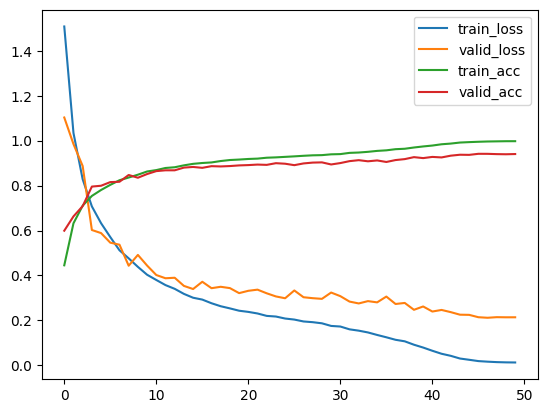

In [64]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(trainer.metrics['train']['loss'],label='train_loss')
plt.plot(trainer.metrics['test']['loss'],label='valid_loss')
plt.plot(trainer.metrics['train']['acc'],label='train_acc')
plt.plot(trainer.metrics['test']['acc'],label='valid_acc')
plt.legend()
plt.show()